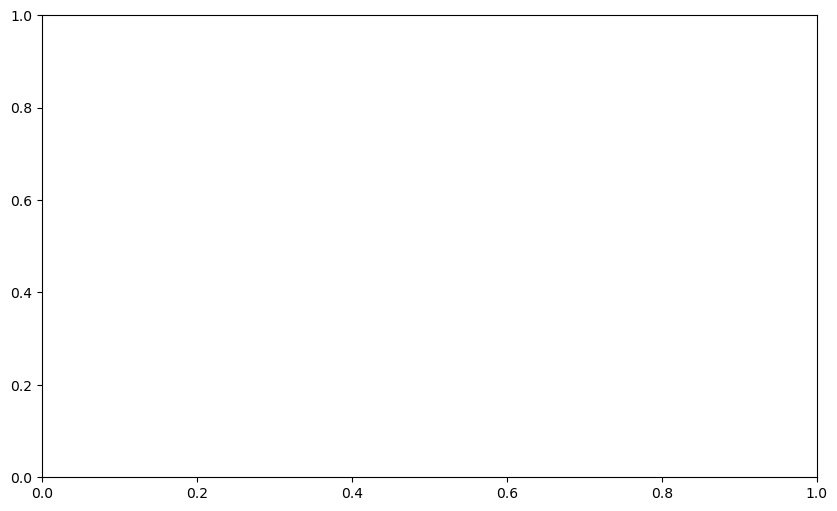

In [1]:
import tkinter as tk
from tkinter import filedialog, ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np

class CellDistributionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Cell Distribution Analysis")

        self.file_path = None
        self.data = {}
        self.marked_points = []
        self.hover_text = None
        self.plot_lines = {}  
        self.checkboxes = {} 
        self.main_container = ttk.PanedWindow(self.root, orient=tk.HORIZONTAL)
        self.main_container.pack(fill=tk.BOTH, expand=True)
        self.setup_sidebar()
        self.content_frame = ttk.Frame(self.main_container)
        self.main_container.add(self.content_frame)

        self.setup_ui()
        self.setup_plot()

    def setup_sidebar(self):
        self.sidebar = ttk.Frame(self.main_container, padding="5")
        self.main_container.add(self.sidebar)
        self.canvas = tk.Canvas(self.sidebar, width=200)
        self.scrollbar = ttk.Scrollbar(self.sidebar, orient="vertical", command=self.canvas.yview)
        self.scrollable_frame = ttk.Frame(self.canvas)

        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all"))
        )

        self.canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        ttk.Label(self.sidebar, text="Available Combinations").pack()
        self.canvas.pack(side="left", fill="both", expand=True)
        self.scrollbar.pack(side="right", fill="y")

    def setup_ui(self):
        input_frame = ttk.Frame(self.content_frame, padding="5")
        input_frame.pack(fill=tk.X)
        ttk.Label(input_frame, text="Resolution (mV):").pack(side=tk.LEFT)
        self.resolution_var = tk.StringVar(value="40")
        ttk.Entry(input_frame, textvariable=self.resolution_var, width=10).pack(side=tk.LEFT, padx=5)
        ttk.Label(input_frame, text="WLS:").pack(side=tk.LEFT)
        self.wls_var = tk.StringVar()
        ttk.Entry(input_frame, textvariable=self.wls_var, width=10).pack(side=tk.LEFT, padx=5)
        ttk.Label(input_frame, text="SSL:").pack(side=tk.LEFT)
        self.ssl_var = tk.StringVar()
        ttk.Entry(input_frame, textvariable=self.ssl_var, width=10).pack(side=tk.LEFT, padx=5)

        button_frame = ttk.Frame(self.content_frame, padding="5")
        button_frame.pack(fill=tk.X)

        ttk.Button(button_frame, text="Browse", command=self.load_file).pack(side=tk.LEFT, padx=5)
        ttk.Button(button_frame, text="Plot Manual", command=self.plot_manual).pack(side=tk.LEFT, padx=5)
        ttk.Button(button_frame, text="Plot Selected", command=self.plot_selected).pack(side=tk.LEFT, padx=5)
        ttk.Button(button_frame, text="Undo Mark", command=self.undo_mark).pack(side=tk.LEFT, padx=5)
        ttk.Button(button_frame, text="Clear Marks", command=self.clear_marks).pack(side=tk.LEFT, padx=5)
        ttk.Button(button_frame, text="Clear Plots", command=self.clear_plots).pack(side=tk.LEFT, padx=5)

    def setup_plot(self):
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.canvas_plot = FigureCanvasTkAgg(self.fig, master=self.content_frame)
        self.canvas_plot.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        self.fig.canvas.mpl_connect("button_press_event", self.onclick)
        self.fig.canvas.mpl_connect("motion_notify_event", self.on_hover)

    def update_checkboxes(self):
        for widget in self.scrollable_frame.winfo_children():
            widget.destroy()
        self.checkboxes.clear()
        for wls, ssl in sorted(self.data.keys()):
            var = tk.BooleanVar()
            self.checkboxes[(wls, ssl)] = var
            ttk.Checkbutton(
                self.scrollable_frame,
                text=f"WLS: {wls}, SSL: {ssl}",
                variable=var,
                command=self.plot_selected
            ).pack(anchor="w", padx=5, pady=2)

    def plot_manual(self):
        wls = self.wls_var.get().strip()
        ssl = self.ssl_var.get().strip()

        try:
            resolution = int(self.resolution_var.get())
            if resolution <= 0:
                raise ValueError
        except ValueError:
            messagebox.showerror("Invalid Resolution", "Please enter a valid positive integer for resolution.")
            return

        if (wls, ssl) in self.data:
            y_raw = self.data[(wls, ssl)]
            y = [np.log10(y_val) if y_val > 0 else 0 for y_val in y_raw]
            start_voltage = -2400
            x = np.arange(start_voltage, start_voltage + len(y) * resolution, resolution)
            self.x_data = x
            self.y_data = y

            line, = self.ax.plot(x, y, '-', label=f"WLS:{wls}, SSL:{ssl}")
            self.plot_lines[(wls, ssl)] = line

            self.ax.set_title("Cell Distribution")
            self.ax.set_xlabel("Voltage (mV)")
            self.ax.set_ylabel("Log10(Value)")
            self.ax.legend()
            self.ax.grid(True)
            self.canvas_plot.draw()
        else:
            messagebox.showerror("Data Not Found", "No matching data for the given WLS and SSL.")

    def load_file(self):
        self.file_path = filedialog.askopenfilename(filetypes=[("Text file", "*.txt")])
        if self.file_path:
            self.parse_file()
            self.update_checkboxes()

    def parse_file(self):
        self.data.clear()
        current_wls, current_ssl = None, None
        current_data = []

        with open(self.file_path, 'r') as file:
            for line in file:
                line = line.strip()

                if "START_SANPO" in line:
                    if current_wls is not None and current_ssl is not None and current_data:
                        self.data[(current_wls, current_ssl)] = current_data
                    current_wls, current_ssl = None, None
                    current_data = []

                elif "WLS:" in line and "SSL:" in line:
                    parts = line.split(',')
                    for part in parts:
                        if "WLS:" in part:
                            current_wls = part.split("WLS:")[1].strip()
                        if "SSL:" in part:
                            current_ssl = part.split("SSL:")[1].strip()

                elif line.isdigit() or (line.startswith('-') and line[1:].isdigit()):
                    current_data.append(float(line))

                elif "END_SANPO" in line:
                    if current_wls is not None and current_ssl is not None and current_data:
                        self.data[(current_wls, current_ssl)] = current_data

    def plot_selected(self):
        try:
            resolution = int(self.resolution_var.get())
            if resolution <= 0:
                raise ValueError
        except ValueError:
            messagebox.showerror("Invalid Resolution", "Please enter a valid positive integer for resolution.")
            return

        self.ax.clear()
        self.plot_lines.clear()

        for (wls, ssl), var in self.checkboxes.items():
            if var.get():  
                y_raw = self.data[(wls, ssl)]
                y = [np.log10(y_val) if y_val > 0 else 0 for y_val in y_raw]
                start_voltage = -2400
                x = np.arange(start_voltage, start_voltage + len(y) * resolution, resolution)
                
                line, = self.ax.plot(x, y, '-', label=f"WLS:{wls}, SSL:{ssl}")
                self.plot_lines[(wls, ssl)] = line
                self.x_data = x
                self.y_data = y

        if self.plot_lines:
            self.ax.set_title("Cell Distribution")
            self.ax.set_xlabel("Voltage (mV)")
            self.ax.set_ylabel("Log10(Value)")
            self.ax.legend()
            self.ax.grid(True)
            self.canvas_plot.draw()

    def clear_plots(self):
        self.ax.clear()
        self.plot_lines.clear()
        self.canvas_plot.draw()
        for var in self.checkboxes.values():
            var.set(False)

    def find_nearest(self, x_click):
        idx = np.searchsorted(self.x_data, x_click)
        if idx == 0:
            return self.x_data[0], self.y_data[0]
        elif idx >= len(self.x_data):
            return self.x_data[-1], self.y_data[-1]
        else:
            x1, x2 = self.x_data[idx - 1], self.x_data[idx]
            y1, y2 = self.y_data[idx - 1], self.y_data[idx]
            slope = (y2 - y1) / (x2 - x1)
            y_click = y1 + slope * (x_click - x1)
            return x_click, y_click

    def onclick(self, event):
        if event.inaxes == self.ax and hasattr(self, 'x_data'):
            x_click = event.xdata
            if x_click is None:
                return
            
            x_val, y_val = self.find_nearest(x_click)
            vline = self.ax.axvline(x=x_val, color='r', linestyle=':', alpha=0.5)
            marker = self.ax.plot(x_val, y_val, 'ro')
            text_label = self.ax.text(x_val, min(self.y_data) - 0.1,
                                    f"{x_val:.2f}",
                                    fontsize=9, color='black', ha='center')
            
            self.marked_points.append((vline, marker, text_label))
            self.canvas_plot.draw_idle()

    def on_hover(self, event):
        if event.inaxes == self.ax and hasattr(self, 'x_data'):
            x_hover = event.xdata
            if x_hover is None:
                return

            x_val, y_val = self.find_nearest(x_hover)

            if hasattr(self, 'hover_text') and self.hover_text:
                self.hover_text.remove()
            if hasattr(self, 'hover_arrow') and self.hover_arrow:
                self.hover_arrow.remove()
            if hasattr(self, 'hover_line') and self.hover_line:
                self.hover_line.remove()

            self.hover_line = self.ax.axvline(x=x_val, color='black', linestyle='dotted', alpha=0.7)

            arrow_x_offset = 50
            arrow_y_offset = 0.3
            self.hover_arrow = self.ax.annotate("", xy=(x_val, y_val),
                                              xytext=(x_val + arrow_x_offset, y_val + arrow_y_offset),
                                              arrowprops=dict(arrowstyle="->", color='black'))

            self.hover_text = self.ax.text(x_val + arrow_x_offset, y_val + arrow_y_offset + 0.1, f"{y_val:.2f}",
                                         fontsize=9, color='black', ha='center',
                                         bbox=dict(facecolor='white', alpha=0.7))

            self.canvas_plot.draw_idle()
        else:
            if hasattr(self, 'hover_text') and self.hover_text:
                self.hover_text.remove()
                self.hover_text = None
            if hasattr(self, 'hover_arrow') and self.hover_arrow:
                self.hover_arrow.remove()
                self.hover_arrow = None
            if hasattr(self, 'hover_line') and self.hover_line:
                self.hover_line.remove()
                self.hover_line = None

            self.canvas_plot.draw_idle()

    def undo_mark(self):
        if self.marked_points:
            vline, marker, text_label = self.marked_points.pop()
            vline.remove()
            marker[0].remove()
            text_label.remove()
            self.canvas_plot.draw_idle()

    def clear_marks(self):
        while self.marked_points:
            self.undo_mark()

if __name__ == "__main__":
    root = tk.Tk()
    app = CellDistributionApp(root)
    root.mainloop()